# Selection of Galactic Plane Region

A number of specific regions of interest in the Galactic Plane and Magellanic Clouds were identified in several White Papers and Cadence Notes, as describe in Street et al. (in prep).  These science regions can be overlaid as HEALpixel maps, where each pixel recieves a vote according to the number of science cases that are interested in it. 

**Please note that more science regions of interest are welcome and can be easily added!**

The maps are produced on a per-filter basis in order to represent the differences in weighting on different filters for different science cases.  

This notebook is designed to demonstrate how different regions can be selected by setting different numerical thresholds.

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from os import path, mkdir
from sys import argv, exit
from sys import path as pythonpath
pythonpath.append('../')
from astropy import units as u
from astropy.coordinates import Galactic, TETE, SkyCoord
from astropy.io import fits
from astropy.table import Table, Column
from pylab import cm
import generate_sky_maps

The regions of interest to each science case are available from the Galactic Science priority maps. Throughout we use the following configuration of the HEALpixel resolution:

In [2]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
PIXAREA = hp.nside2pixarea(NSIDE,degrees=True)

Function to load the pre-tabulated HEALpixel data from the map combining different science cases together.  
**Note that this map has not been aggregated to consolidate the survey region - this was done for the proposed region for baseline_v3**

In [9]:
# Load the galactic science priority map data from the "sum" file
home = path.expanduser("~")
#galSciencePriorityMapFile = os.path.join(home, 'rubin_sim_data/maps/GalacticPlanePriorityMaps/priority_GalPlane_footprint_map_data_sum.fits')
galSciencePriorityMapFile = path.join(home, 'software/LSST-TVS_software_tools/footprint_maps/priority_GalPlane_footprint_map_data_sum.fits')

with fits.open(galSciencePriorityMapFile) as hdul:
    galSciencePriorityMapTable = hdul[1].data

# The sum priority map sums the priority assigned to all HEALpixels over all 6 LSST filters.  
# For ease of explanation, it is valid to average this over all filters here.  
# We also select the combined region map, as opposed to the maps for the distinct science cases
combinedMap = getattr(galSciencePriorityMapTable, 'combined_map')
combinedMap /= 6

Here we plot the full map of the map combining all science regions of interest, for reference.  This is equivalent to the desired survey footprint, if there were no external pressures limiting the maximum area that can be surveyed at a reasonable cadence.  

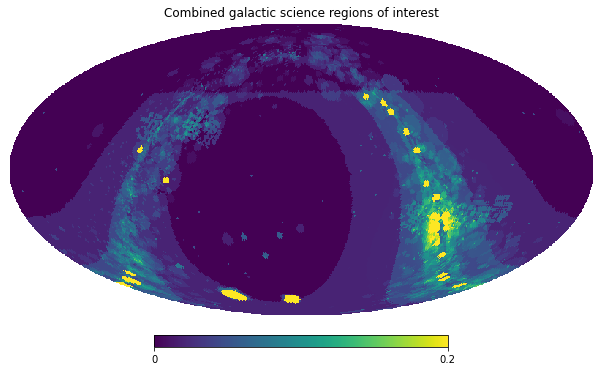

In [14]:
hp.mollview(combinedMap, title='Combined galactic science regions of interest',min=0.0, max=0.2)

The value of each HEALpixel represents the number of science cases which selected that pixel as important for the science case in question.  Higher values therefore identify regions of interest to multiple science cases.  In order not to neglect unique science that only Rubin can do, a relative weighting can be given to each science case, assigned by agreement within the Rubin community. 

For comparison, below is a map of galactic stellar density (based on the TRILEGAL model), plotted on the same projection. 

0.0 180.0 -180.0 180.0


<Figure size 720x720 with 0 Axes>

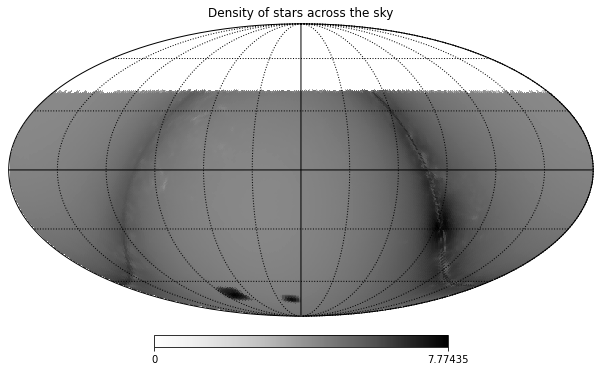

In [18]:
config = {'star_map_dir': '/Users/rstreet1/rubin_sim_data/maps/TriMaps',
        'GP': {'data_file': 'TRIstarDensity_r_nside_64_ext.npz'}}
star_density_map = generate_sky_maps.load_star_density_data(config,limiting_mag=27.5)
hp_star_density = generate_sky_maps.rotateHealpix(star_density_map)
idx = hp_star_density > 0.0
hp_log_star_density = np.zeros(len(hp_star_density))
hp_log_star_density[idx] = np.log10(hp_star_density[idx])


fig = plt.figure(3,(10,10))
hp.mollview(hp_log_star_density, title='Density of stars across the sky',
      cmap=cm.Greys)
hp.graticule()


We can apply different selection thresholds to the combined science maps above to explore the region that would be included, as below. 

Number of HEALpixels in desired survey region with priority > 0.01: 24526
Number of HEALpixels in desired survey region with priority > 0.035: 9840
Number of HEALpixels in desired survey region with priority > 0.060000000000000005: 4644
Number of HEALpixels in desired survey region with priority > 0.085: 2021
Number of HEALpixels in desired survey region with priority > 0.11: 978
Number of HEALpixels in desired survey region with priority > 0.135: 640
Number of HEALpixels in desired survey region with priority > 0.16000000000000003: 512
Number of HEALpixels in desired survey region with priority > 0.18500000000000003: 455
Number of HEALpixels in desired survey region with priority > 0.21000000000000002: 424
Number of HEALpixels in desired survey region with priority > 0.23500000000000001: 403
Number of HEALpixels in desired survey region with priority > 0.26: 386
Number of HEALpixels in desired survey region with priority > 0.28500000000000003: 301
Number of HEALpixels in desired surve

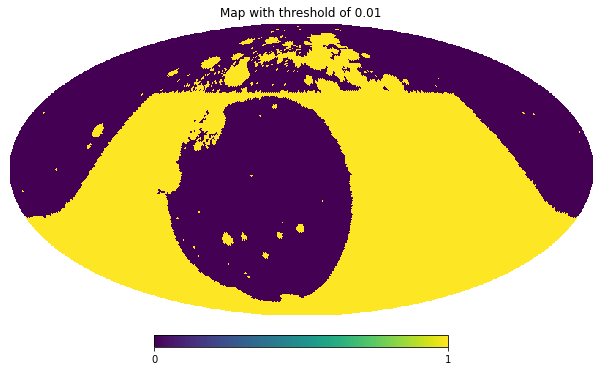

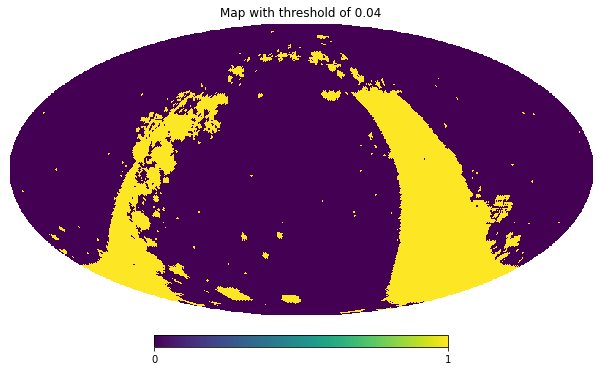

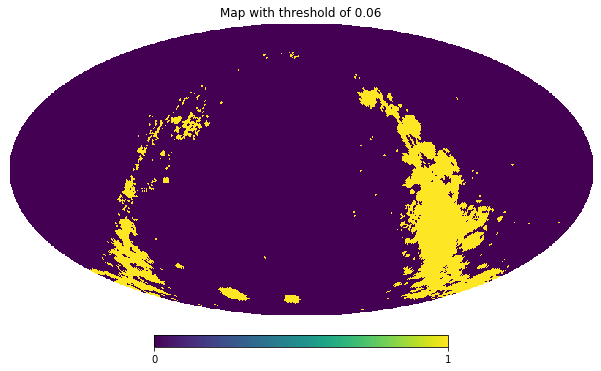

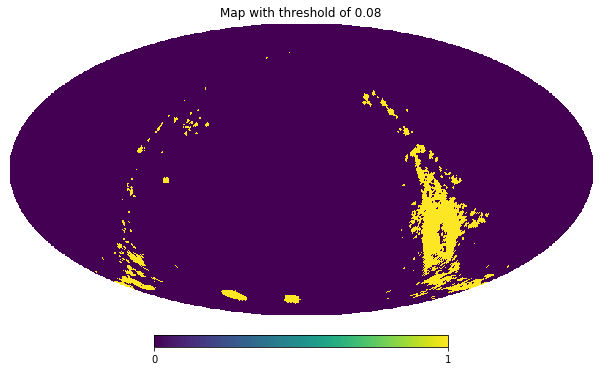

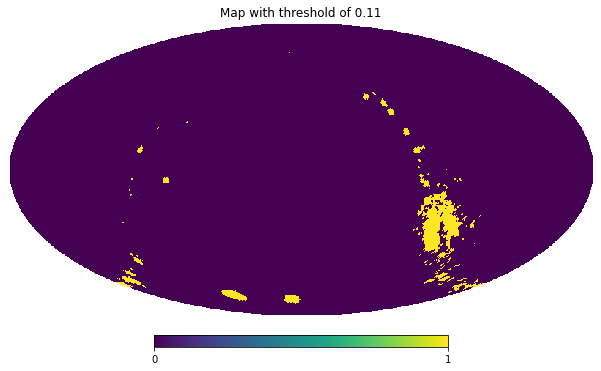

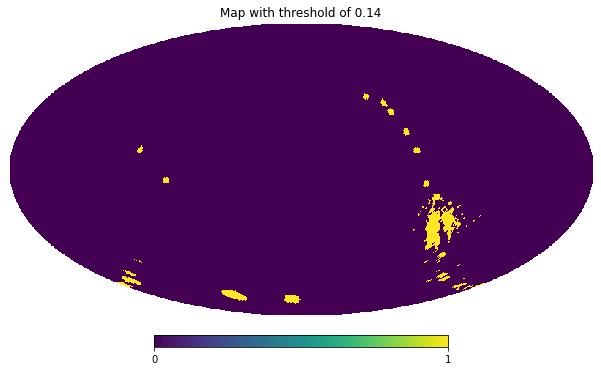

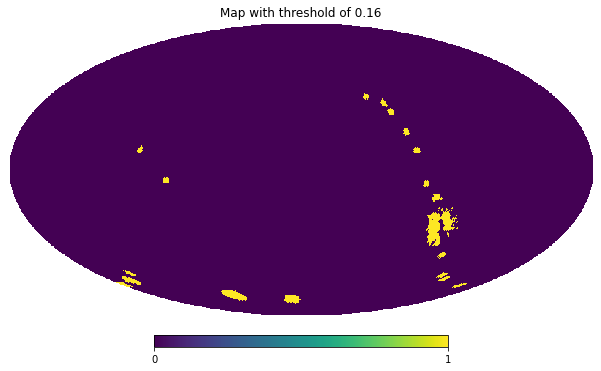

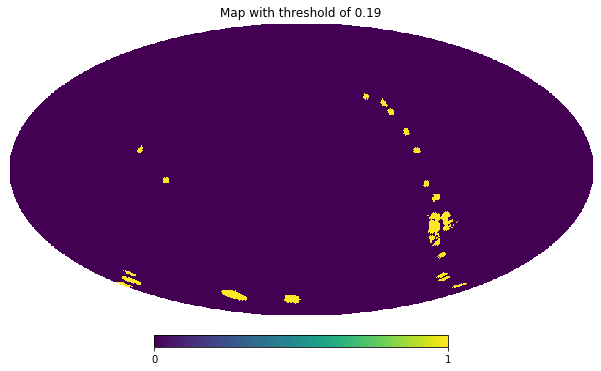

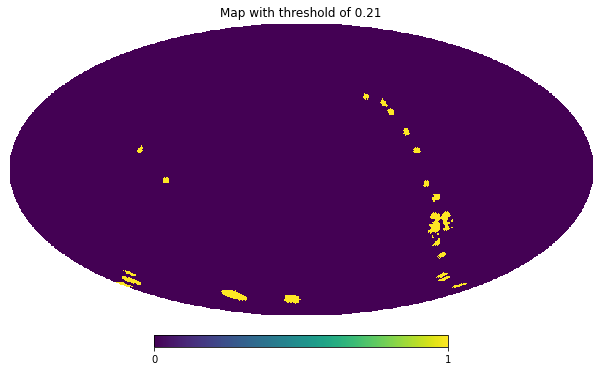

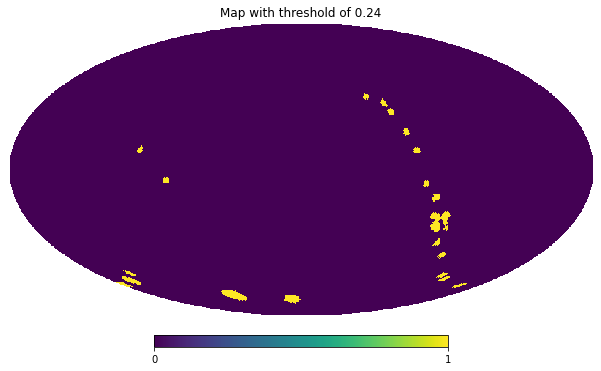

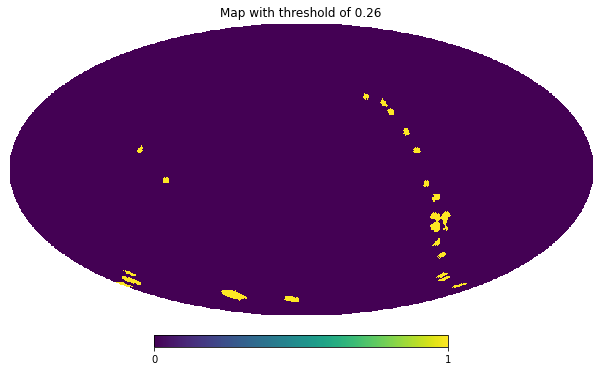

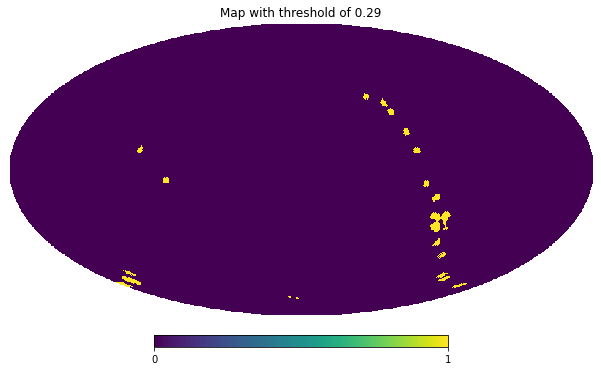

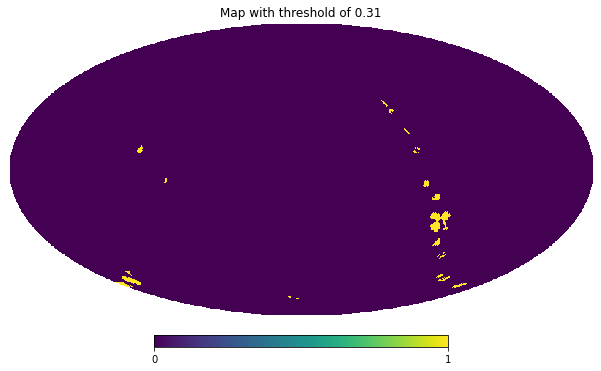

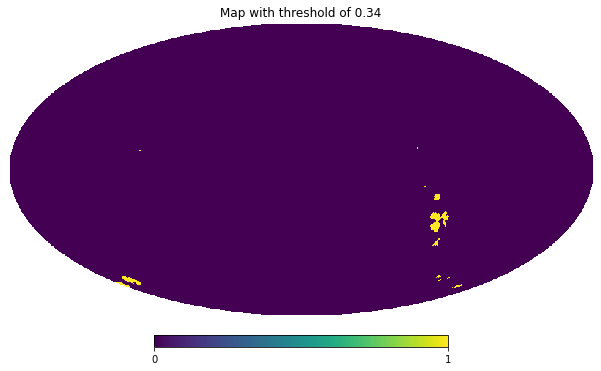

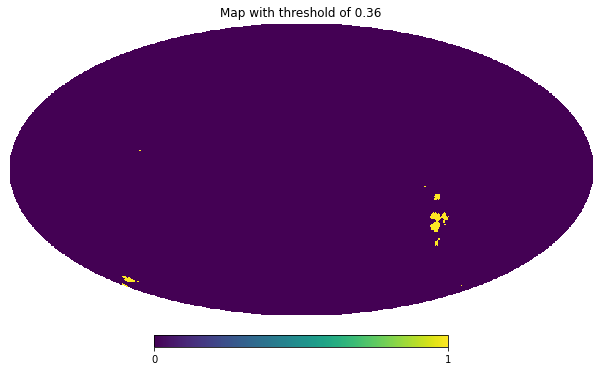

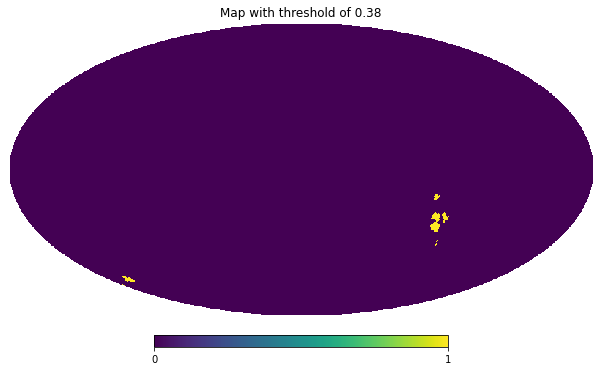

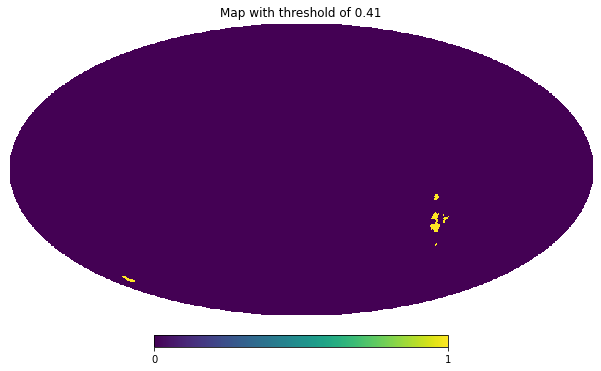

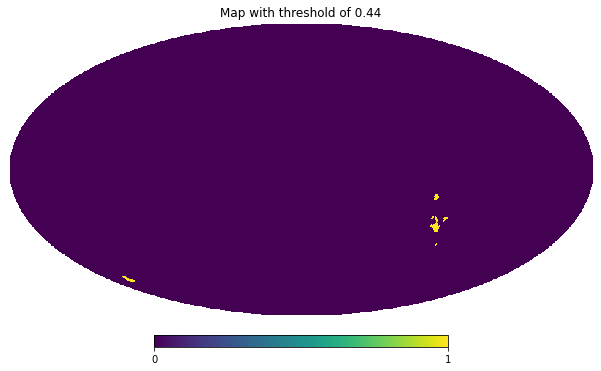

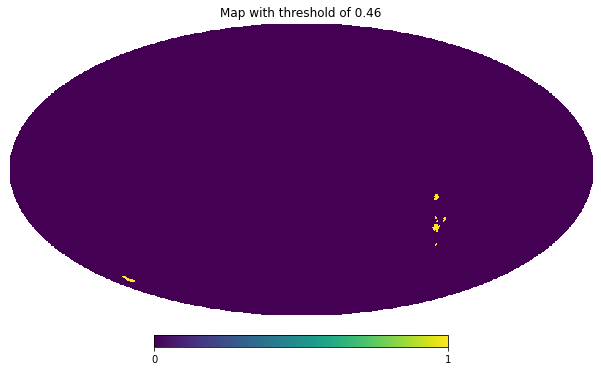

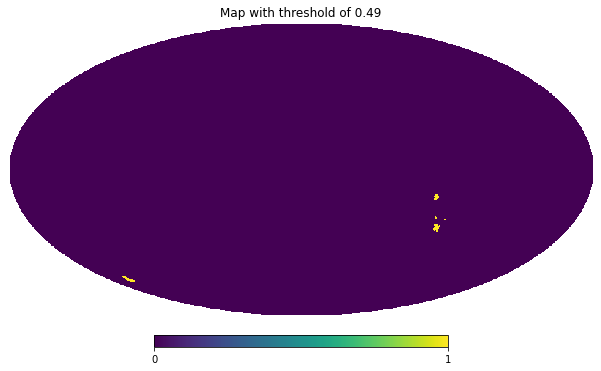

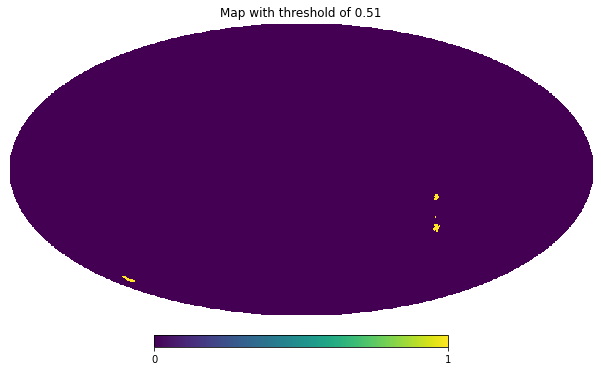

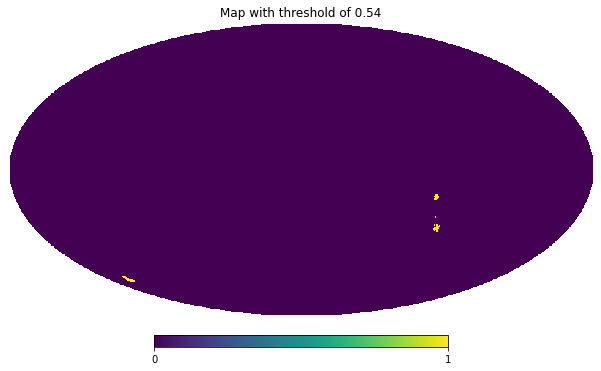

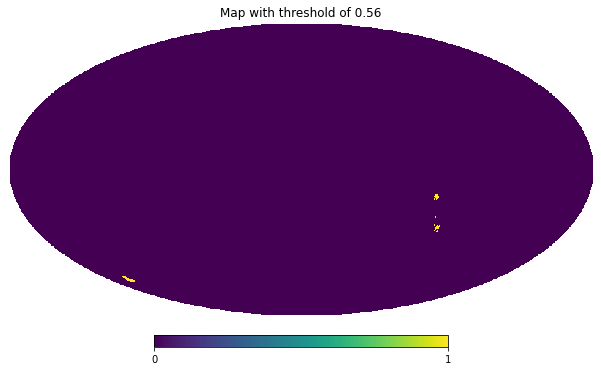

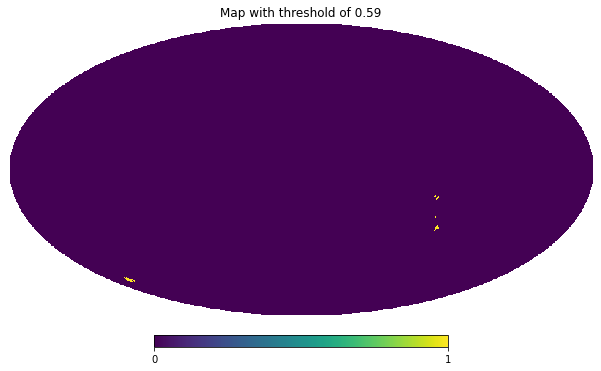

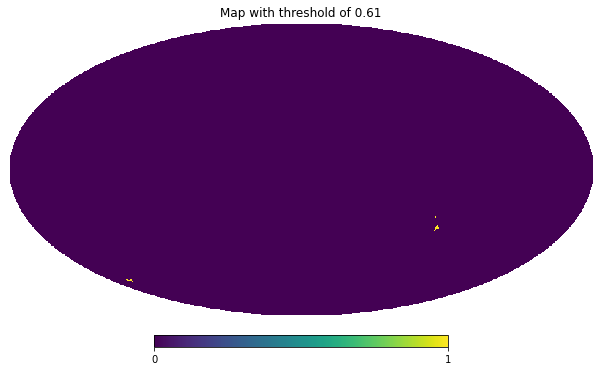

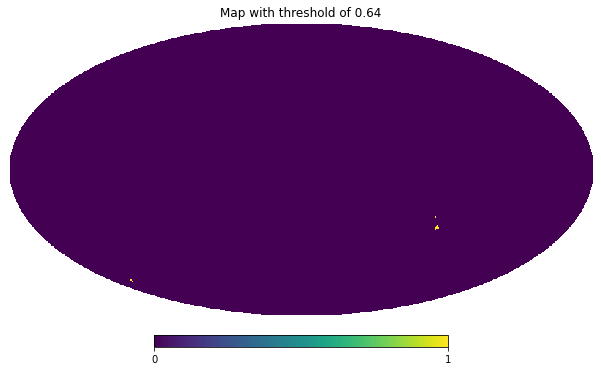

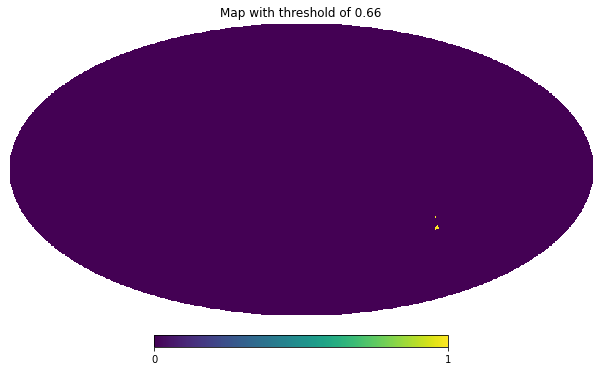

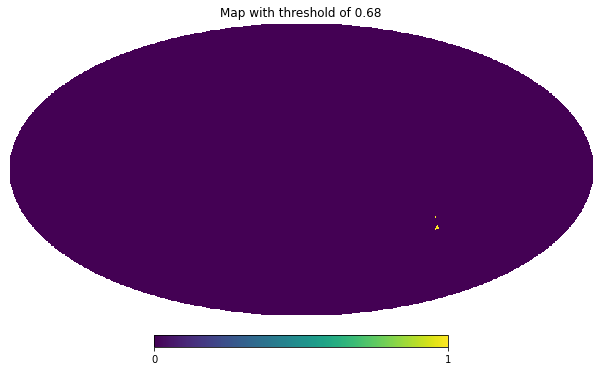

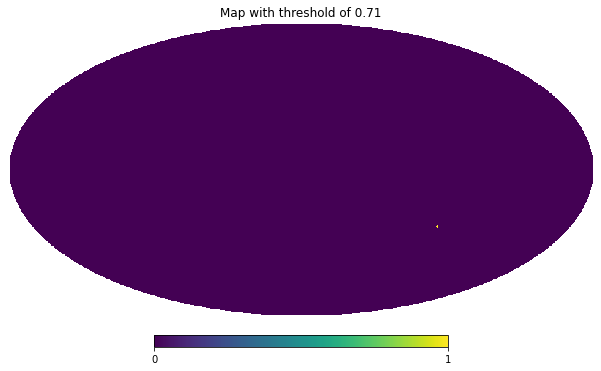

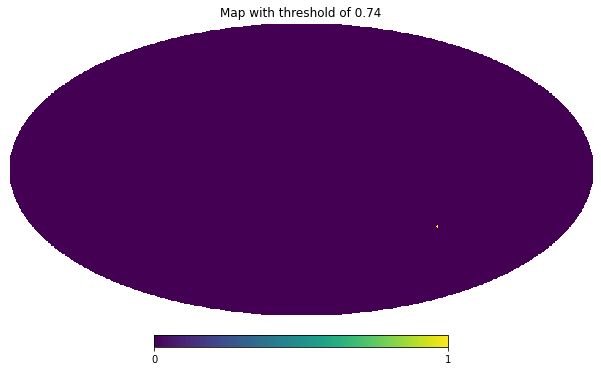

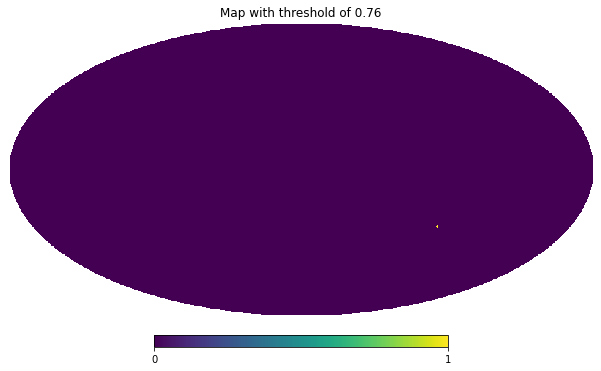

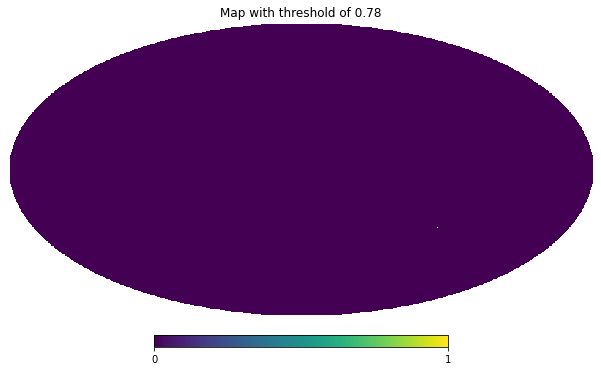

In [25]:
thresholdRange = np.arange(0.01, 0.8, 0.025)

for threshold in thresholdRange:
    mapPixels = np.where(combinedMap > threshold)[0]
    print('Number of HEALpixels in desired survey region with priority > '+str(threshold)+': '+str(len(mapPixels)))
    selectedMap = np.zeros(len(combinedMap))
    selectedMap[mapPixels] = 1.0

    hp.mollview(selectedMap, title='Map with threshold of '+str(round(threshold,2)))

Note that as we increase the threshold, the region of interest fragments.  This is due to a combination of factors: extinction within the Plane creates isolated regions of high stellar density, and some of the regions of interest for time domain, particularly the pencilbeams, were given weight to ensure at least some coverage of high galactic longitude fields, if the SCOC chose to include only a small region in the Galactic Plane.  

**Please note that alternative sets of larger, more contiguous pencilbeams have already been provided and simulated, to minimize the fragmentation issue!** We can revert to using those if prefered. 

Furthermore, clustering algorithms have already been applied to make more aggregated final regions **after** a threshold has been applied to select the region.  
If a lower threshold (i.e. wider-area) map were selected, the clustering algorithm will produce a contiguous survey footprint for that wider area.  